## Imports

In [2]:
import sys
import os
import pickle

library_path = os.path.join('..', '..', '..','UCB-USACE-LSTMs')
sys.path.insert(0, library_path)

from pathlib import Path
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation.metrics import *
from neuralhydrology.nh_run import start_run, eval_run, finetune
from neuralhydrology.utils.nh_results_ensemble import create_results_ensemble
from neuralhydrology.UCB_training.UCB_train import UCB_trainer
from neuralhydrology.UCB_training.UCB_train import clean_daily
from neuralhydrology.UCB_training.UCB_train import combinedPlot
from neuralhydrology.evaluation.metrics import calculate_all_metrics

## Working directory

In [4]:
print("Current Working Directory:", os.getcwd())
print("Train Basin File Exists:", os.path.exists("guerneville"))

Current Working Directory: F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all
Train Basin File Exists: True


## Standard daily LSTM, train on training subset, evaluate on evaluation period (for hyperparameter search)

In [6]:
path_to_csv = Path("F:/Dino/UCB-USACE-LSTMs/data/updated_russian_river_folder/")
path_to_yaml = Path("guerneville_gage_all_basins.yaml")
params = {
    "epochs":16,
    "hidden_size": 256,
    "output_dropout": 0.4,
    "seq_length": 90,
}
#defaults to daily so no need to specify hourly
lstmNoPhysicsDaily = UCB_trainer(path_to_csv, yaml_path = path_to_yaml, hyperparams = params)

In [7]:
lstmNoPhysicsDaily.train()

2025-01-20 13:39:33,242: Logging to F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_133933\output.log initialized.
2025-01-20 13:39:33,244: ### Folder structure created at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_133933
2025-01-20 13:39:33,246: ### Run configurations for testing_run
2025-01-20 13:39:33,248: experiment_name: testing_run
2025-01-20 13:39:33,249: train_basin_file: guerneville
2025-01-20 13:39:33,251: validation_basin_file: guerneville
2025-01-20 13:39:33,252: test_basin_file: guerneville
2025-01-20 13:39:33,254: train_start_date: 1994-10-01 00:00:00
2025-01-20 13:39:33,255: train_end_date: 2002-09-30 00:00:00
2025-01-20 13:39:33,257: validation_start_date: 2002-10-01 00:00:00
2025-01-20 13:39:33,404: validation_end_date: 2005-09-30 00:00:00
2025-01-20 13:39:33,407: test_start_date: 2005-10-01 00:00:00
2025-01-20 13:39:33,409: test_end_date: 2009-09-30 00:00:00
2025-01-20 13:39:33,413: device: cpu
2025-01-2

F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self

# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2025-01-20 13:40:38,319: Stored metrics at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_133933\validation\model_epoch016\validation_metrics.csv
2025-01-20 13:40:38,322: Stored results at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_133933\validation\model_epoch016\validation_results.p


WindowsPath('F:/Dino/UCB-USACE-LSTMs/neuralhydrology/guerneville_all/runs/testing_run_2001_133933')

Using basin: Guerneville
Using target variable: NR GUERNEVILLE FLOW COE GRN
Observed_key: NR GUERNEVILLE FLOW COE GRN_obs
Simulated_key: NR GUERNEVILLE FLOW COE GRN_sim


F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please

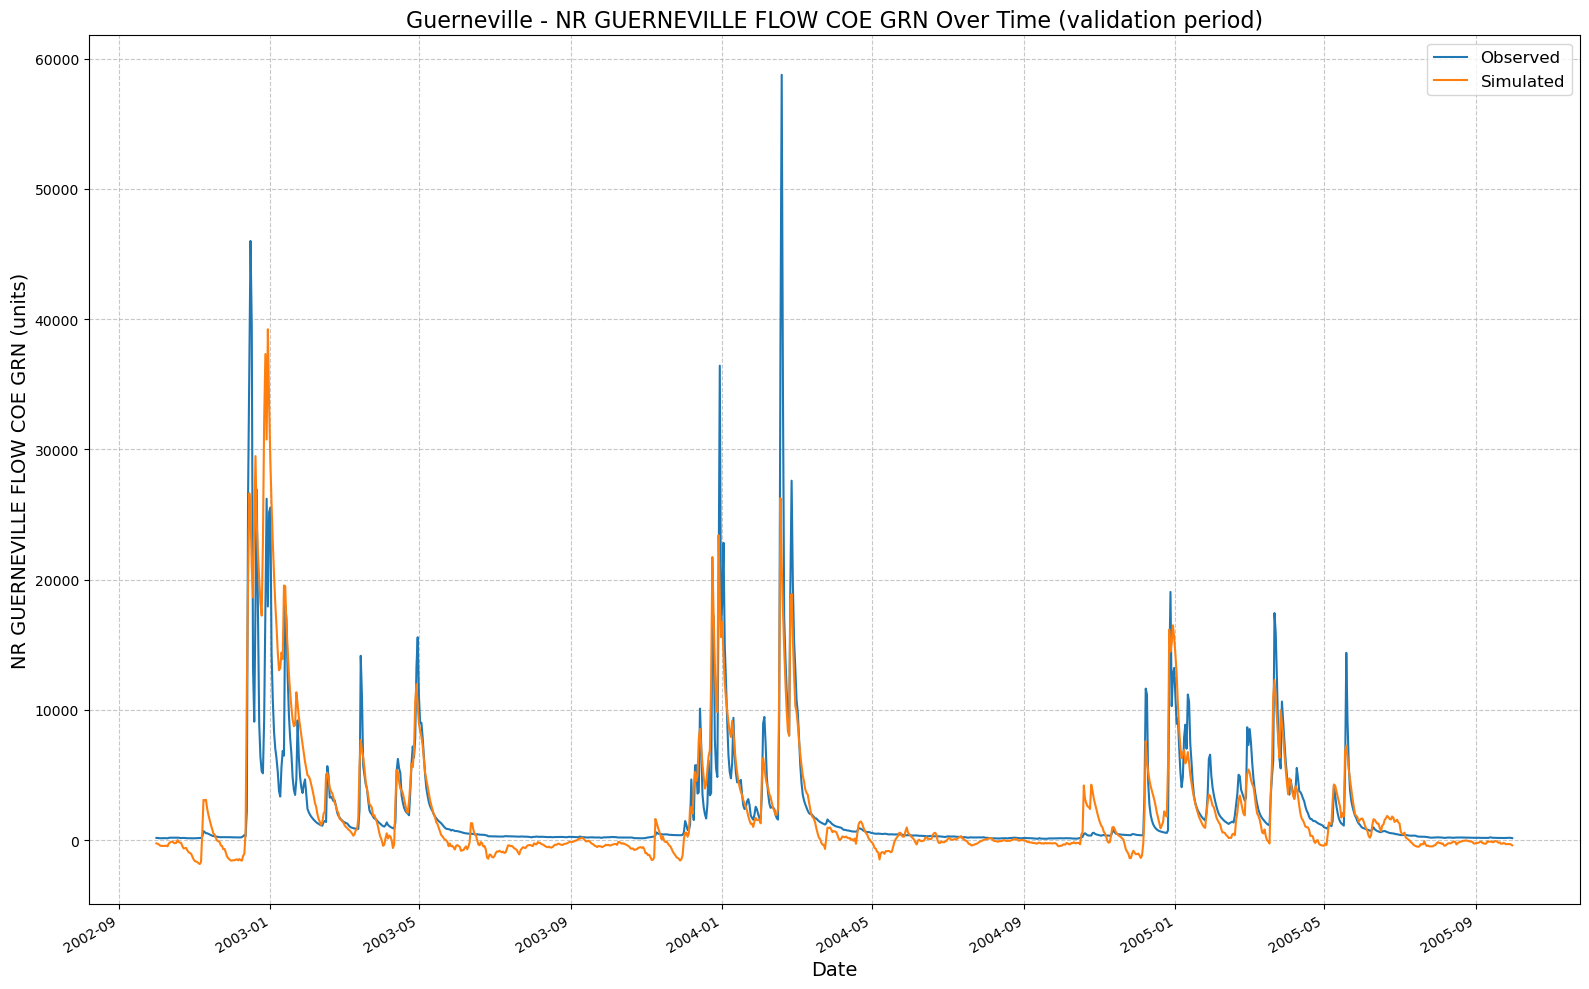

[INFO] CSV output saved at: F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_133933\results_output_validation.csv


({'NSE': 0.6629254221916199,
  'MSE': 8344521.0,
  'RMSE': 2888.688456722185,
  'KGE': 0.824621209327443,
  'Alpha-NSE': 1.0235889727872236,
  'Beta-KGE': 0.9425244927406311,
  'Beta-NSE': -0.0277408510393582,
  'Pearson-r': 0.8359943700786756,
  'FHV': -6.380283832550049,
  'FMS': 771.3613770264176,
  'FLV': 99.99999947157285,
  'Peak-Timing': 1.0,
  'Peak-MAPE': 43.33940505981445},
 WindowsPath('F:/Dino/UCB-USACE-LSTMs/neuralhydrology/guerneville_all/runs/testing_run_2001_133933/results_output_validation.csv'))

In [8]:
lstmNoPhysicsDaily.results()

## Physics-informed LSTM, train on training subset, evaluate on evaluation period (for hyperparameter search)

In [10]:
path_to_csv = Path("F:/Dino/UCB-USACE-LSTMs/data/updated_russian_river_folder/")
path_to_yaml = Path("guerneville_gage_all_basins.yaml")
path_to_physics_data = Path("F:/Dino/UCB-USACE-LSTMs/data/updated_russian_river_folder/Guerneville_all_basins_daily.csv")
params = {
    "epochs":16,
    "hidden_size": 256,
    "output_dropout": 0.4,
    "seq_length": 90,
}
features_with_physics = [
    # From Daily.csv
    # Subbasins (precip & ET)
    "BIG SULPHUR CR ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "DRY CREEK 10 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "DRY CREEK 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "DRY CREEK 30 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "EF RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "GREEN VALLEY ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "LAGUNA ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 30 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 40 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 50 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 60 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 70 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "SANTA ROSA CR 10 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "SANTA ROSA CR 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "WF RUSSIAN ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "BIG SULPHUR CR PRECIP-INC SCREENED",
    "DRY CREEK 10 PRECIP-INC SCREENED",
    "DRY CREEK 20 PRECIP-INC SCREENED",
    "DRY CREEK 30 PRECIP-INC SCREENED",
    "EF RUSSIAN 20 PRECIP-INC SCREENED",
    "GREEN VALLEY PRECIP-INC SCREENED",
    "LAGUNA PRECIP-INC SCREENED",
    "RUSSIAN 20 PRECIP-INC SCREENED",
    "RUSSIAN 30 PRECIP-INC SCREENED",
    "RUSSIAN 40 PRECIP-INC SCREENED",
    "RUSSIAN 50 PRECIP-INC SCREENED",
    "RUSSIAN 60 PRECIP-INC SCREENED",
    "RUSSIAN 70 PRECIP-INC SCREENED",
    "SANTA ROSA CR 10 PRECIP-INC SCREENED",
    "SANTA ROSA CR 20 PRECIP-INC SCREENED",
    "WF RUSSIAN PRECIP-INC SCREENED",
  # met gages: UKIAH and SANTA ROSA
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    "SANTA ROSA CA HUMIDITY USAF-NOAA",
    "SANTA ROSA CA SOLAR RADIATION USAF-NOAA",
    "SANTA ROSA CA TEMPERATURE USAF-NOAA",
    "SANTA ROSA CA WINDSPEED USAF-NOAA",
  # Boundary Conditions (inflows)
    "UKIAH CA FLOW USGS-MERGED",
    "GEYSERVILLE CA FLOW USGS-MERGED",
    "POTTER VALLEY CA FLOW USGS_ADJUSTED",

    # from Guerneville_all_basins_daily.csv
    "Guerneville Gage FLOW",
    "Big Sulphur Cr ET-POTENTIAL",
    "Big Sulphur Cr FLOW",
    "Big Sulphur Cr FLOW-BASE",
    "Big Sulphur Cr INFILTRATION",
    "Big Sulphur Cr PERC-SOIL",
    "Big Sulphur Cr SATURATION FRACTION",
    "Dry Creek 10 ET-POTENTIAL",
    "Dry Creek 10 FLOW",
    "Dry Creek 10 FLOW-BASE",
    "Dry Creek 10 INFILTRATION",
    "Dry Creek 10 PERC-SOIL",
    "Dry Creek 10 SATURATION FRACTION",
    "Green Valley ET-POTENTIAL",
    "Green Valley FLOW",
    "Green Valley FLOW-BASE",
    "Green Valley INFILTRATION",
    "Green Valley PERC-SOIL",
    "Green Valley SATURATION FRACTION",
    "Laguna ET-POTENTIAL",
    "Laguna FLOW",
    "Laguna FLOW-BASE",
    "Laguna INFILTRATION",
    "Laguna PERC-SOIL",
    "Laguna SATURATION FRACTION",
    "Russian 20 ET-POTENTIAL",
    "Russian 20 FLOW",
    "Russian 20 FLOW-BASE",
    "Russian 20 INFILTRATION",
    "Russian 20 PERC-SOIL",
    "Russian 20 SATURATION FRACTION",
    "Russian 30 ET-POTENTIAL",
    "Russian 30 FLOW",
    "Russian 30 FLOW-BASE",
    "Russian 30 INFILTRATION",
    "Russian 30 PERC-SOIL",
    "Russian 30 SATURATION FRACTION",
    "Russian 40 ET-POTENTIAL",
    "Russian 40 FLOW",
    "Russian 40 FLOW-BASE",
    "Russian 40 INFILTRATION",
    "Russian 40 PERC-SOIL",
    "Russian 40 SATURATION FRACTION",
    "Russian 50 ET-POTENTIAL",
    "Russian 50 FLOW",
    "Russian 50 FLOW-BASE",
    "Russian 50 INFILTRATION",
    "Russian 50 PERC-SOIL",
    "Russian 50 SATURATION FRACTION",
    "Russian 60 ET-POTENTIAL",
    "Russian 60 FLOW",
    "Russian 60 FLOW-BASE",
    "Russian 60 INFILTRATION",
    "Russian 60 PERC-SOIL",
    "Russian 60 SATURATION FRACTION",
    "Russian 70 ET-POTENTIAL",
    "Russian 70 FLOW",
    "Russian 70 FLOW-BASE",
    "Russian 70 INFILTRATION",
    "Russian 70 PERC-SOIL",
    "Russian 70 SATURATION FRACTION",
    "Santa Rosa Cr 10 ET-POTENTIAL",
    "Santa Rosa Cr 10 FLOW",
    "Santa Rosa Cr 10 FLOW-BASE",
    "Santa Rosa Cr 10 INFILTRATION",
    "Santa Rosa Cr 10 PERC-SOIL",
    "Santa Rosa Cr 10 SATURATION FRACTION",
    "Santa Rosa Cr 20 ET-POTENTIAL",
    "Santa Rosa Cr 20 FLOW",
    "Santa Rosa Cr 20 FLOW-BASE",
    "Santa Rosa Cr 20 INFILTRATION",
    "Santa Rosa Cr 20 PERC-SOIL",
    "Santa Rosa Cr 20 SATURATION FRACTION",
    "WF Russian ET-POTENTIAL",
    "WF Russian FLOW",
    "WF Russian FLOW-BASE",
    "WF Russian INFILTRATION",
    "WF Russian PERC-SOIL",
    "WF Russian SATURATION FRACTION",
    "Warm Springs Dam Inflow FLOW",
    "Dry Creek 20 ET-POTENTIAL",
    "Dry Creek 20 FLOW",
    "Dry Creek 20 FLOW-BASE",
    "Dry Creek 20 INFILTRATION",
    "Dry Creek 20 PERC-SOIL",
    "Dry Creek 20 SATURATION FRACTION",
    "Dry Creek 30 ET-POTENTIAL",
    "Dry Creek 30 FLOW",
    "Dry Creek 30 FLOW-BASE",
    "Dry Creek 30 INFILTRATION",
    "Dry Creek 30 PERC-SOIL",
    "Dry Creek 30 SATURATION FRACTION",
    "Hopland Gage FLOW",
    "Capella Gage FLOW",
    "EF Russian 20 ET-POTENTIAL",
    "EF Russian 20 FLOW",
    "EF Russian 20 FLOW-BASE",
    "EF Russian 20 INFILTRATION",
    "EF Russian 20 PERC-SOIL",
    "EF Russian 20 SATURATION FRACTION",

    # Reservoirs
    #"Lake Sonoma Storage",
    #"Lake Mendocino Storage",    
    ]
lstmPhysicsDaily = UCB_trainer(path_to_csv, yaml_path= path_to_yaml, hyperparams= params, input_features= features_with_physics, physics_informed=True, physics_data_file=path_to_physics_data, hourly=False)

In [11]:
lstmPhysicsDaily.train()

2025-01-20 13:40:39,306: Logging to F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134039\output.log initialized.
2025-01-20 13:40:39,308: ### Folder structure created at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134039
2025-01-20 13:40:39,309: ### Run configurations for testing_run
2025-01-20 13:40:39,311: experiment_name: testing_run
2025-01-20 13:40:39,312: train_basin_file: guerneville
2025-01-20 13:40:39,314: validation_basin_file: guerneville
2025-01-20 13:40:39,315: test_basin_file: guerneville
2025-01-20 13:40:39,317: train_start_date: 1994-10-01 00:00:00
2025-01-20 13:40:39,318: train_end_date: 2002-09-30 00:00:00
2025-01-20 13:40:39,320: validation_start_date: 2002-10-01 00:00:00
2025-01-20 13:40:39,321: validation_end_date: 2005-09-30 00:00:00
2025-01-20 13:40:39,322: test_start_date: 2005-10-01 00:00:00
2025-01-20 13:40:39,323: test_end_date: 2009-09-30 00:00:00
2025-01-20 13:40:39,324: device: cpu
2025-01-2

F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self

# Validation: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]
2025-01-20 13:41:46,606: Stored metrics at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134039\validation\model_epoch016\validation_metrics.csv
2025-01-20 13:41:46,608: Stored results at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134039\validation\model_epoch016\validation_results.p


WindowsPath('F:/Dino/UCB-USACE-LSTMs/neuralhydrology/guerneville_all/runs/testing_run_2001_134039')

Using basin: Guerneville
Using target variable: NR GUERNEVILLE FLOW COE GRN
Observed_key: NR GUERNEVILLE FLOW COE GRN_obs
Simulated_key: NR GUERNEVILLE FLOW COE GRN_sim


F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please

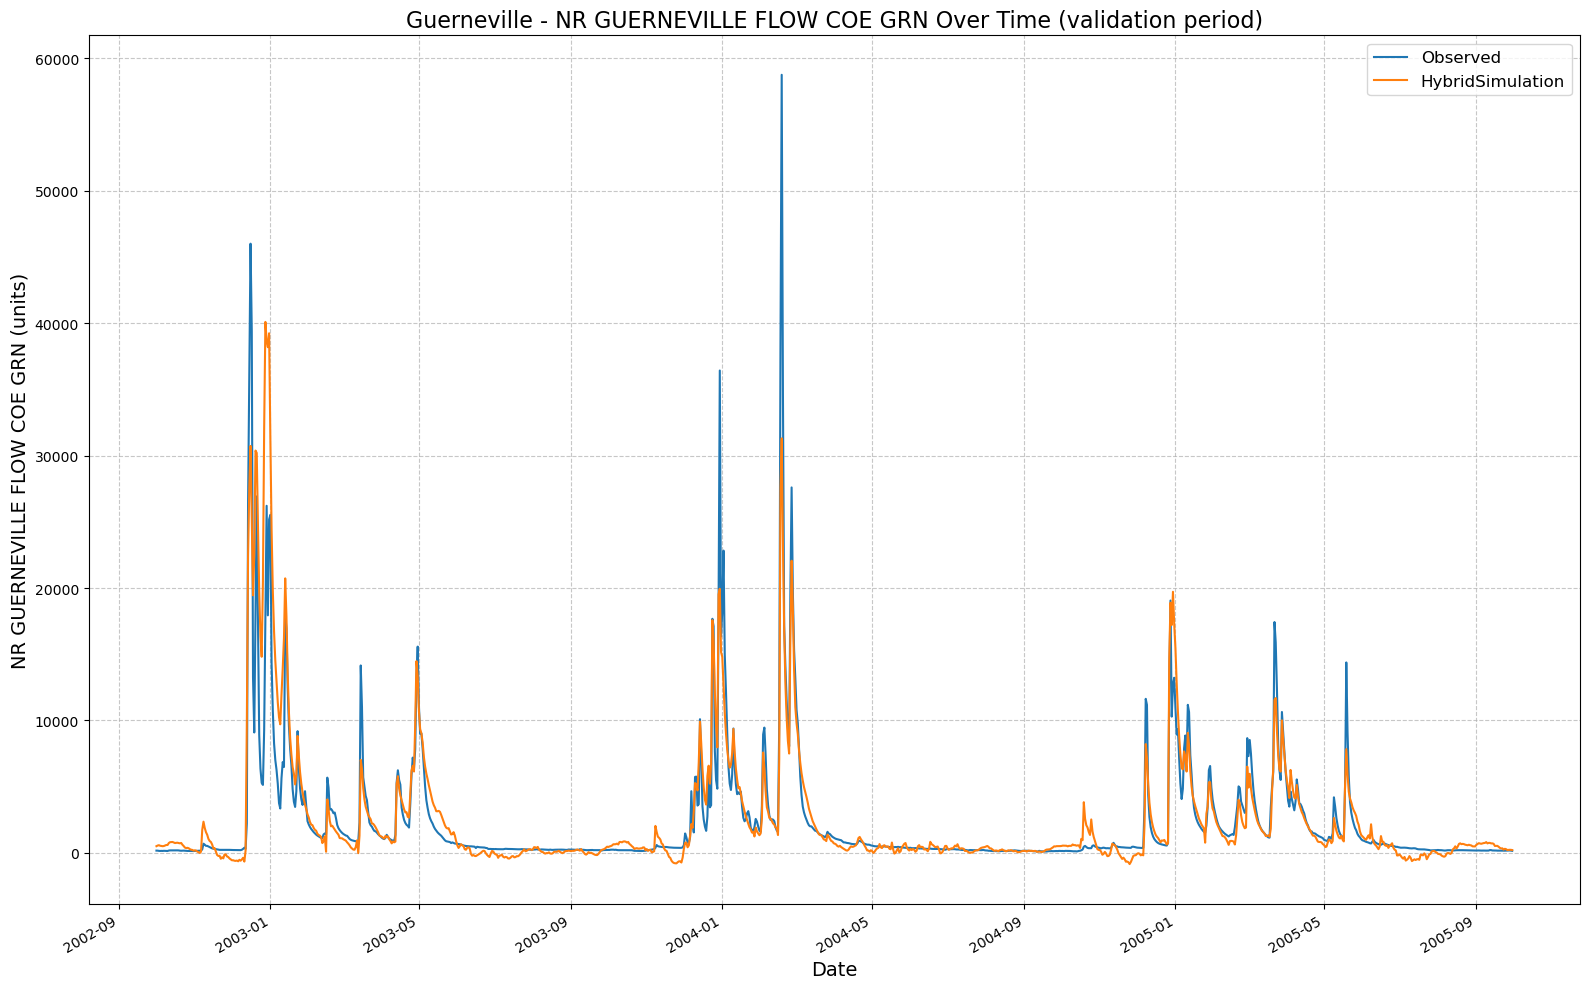

[INFO] CSV output saved at: F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134039\results_output_validation.csv


({'NSE': 0.7611584216356277,
  'MSE': 5912693.5,
  'RMSE': 2431.6030720493836,
  'KGE': 0.8719060454088792,
  'Alpha-NSE': 1.0224271299095198,
  'Beta-KGE': 1.0488173961639404,
  'Beta-NSE': 0.023561985136968704,
  'Pearson-r': 0.8837160936389452,
  'FHV': 0.6413615308701992,
  'FMS': 2.241126562853715,
  'FLV': -1540.951870282825,
  'Peak-Timing': 0.2,
  'Peak-MAPE': 28.12690258026123},
 WindowsPath('F:/Dino/UCB-USACE-LSTMs/neuralhydrology/guerneville_all/runs/testing_run_2001_134039/results_output_validation.csv'))

In [12]:
lstmPhysicsDaily.results()

## Retrain LSTM on entire train period using best hyperparameters, evaluate on test period

In [14]:
path_to_csv = Path("F:/Dino/UCB-USACE-LSTMs/data/updated_russian_river_folder/")
path_to_yaml = Path("guerneville_gage_all_basins.yaml")
params = {
    "epochs":32,
    "hidden_size": 256,
    "output_dropout": 0.4,
    "seq_length": 90,
}
#defaults to daily so no need to specify hourly
lstmNoPhysicsDailyExtended = UCB_trainer(path_to_csv, yaml_path= path_to_yaml, hyperparams= params, hourly=False, extend_train_period=True)

In [15]:
lstmNoPhysicsDailyExtended.train()

2025-01-20 13:41:47,571: Logging to F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134147\output.log initialized.
2025-01-20 13:41:47,574: ### Folder structure created at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134147
2025-01-20 13:41:47,575: ### Run configurations for testing_run
2025-01-20 13:41:47,577: experiment_name: testing_run
2025-01-20 13:41:47,579: train_basin_file: guerneville
2025-01-20 13:41:47,581: validation_basin_file: guerneville
2025-01-20 13:41:47,584: test_basin_file: guerneville
2025-01-20 13:41:47,586: train_start_date: 1994-10-01 00:00:00
2025-01-20 13:41:47,588: train_end_date: 2005-09-30 00:00:00
2025-01-20 13:41:47,590: validation_start_date: 2002-10-01 00:00:00
2025-01-20 13:41:47,592: validation_end_date: 2005-09-30 00:00:00
2025-01-20 13:41:47,593: test_start_date: 2005-10-01 00:00:00
2025-01-20 13:41:47,593: test_end_date: 2009-09-30 00:00:00
2025-01-20 13:41:47,595: device: cpu
2025-01-2

F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self

# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2025-01-20 13:44:30,684: Stored metrics at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134147\validation\model_epoch032\validation_metrics.csv
2025-01-20 13:44:30,687: Stored results at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134147\validation\model_epoch032\validation_results.p


WindowsPath('F:/Dino/UCB-USACE-LSTMs/neuralhydrology/guerneville_all/runs/testing_run_2001_134147')

2025-01-20 13:44:30,858: Using the model weights from F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134147\model_epoch032.pt


F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self

# Evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
2025-01-20 13:44:32,003: Stored metrics at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134147\test\model_epoch032\test_metrics.csv
2025-01-20 13:44:32,005: Stored results at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134147\test\model_epoch032\test_results.p
Using basin: Guerneville
Using target variable: NR GUERNEVILLE FLOW COE GRN
Observed_key: NR GUERNEVILLE FLOW COE GRN_obs
Simulated_key: NR GUERNEVILLE FLOW COE GRN_sim


F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please

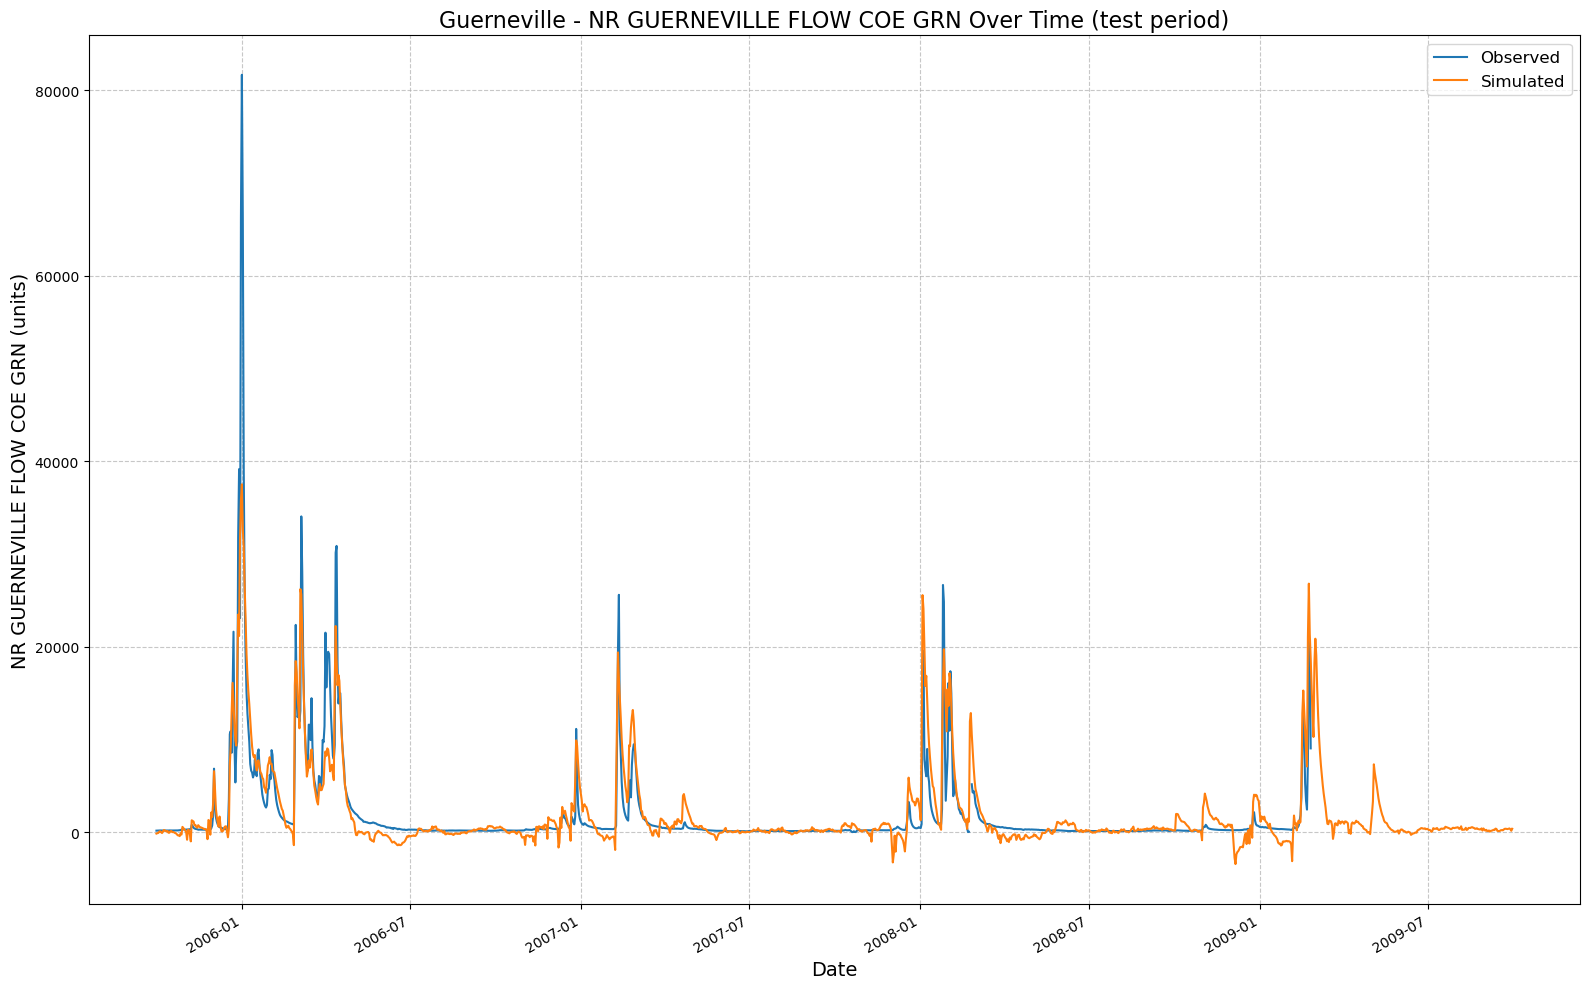

[INFO] CSV output saved at: F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134147\results_output_test.csv


In [16]:
lstm_result_metrics, lstm_result_path = lstmNoPhysicsDailyExtended.results('test')

In [17]:
lstm_result_metrics

{'NSE': 0.7556946128606796,
 'MSE': 7525564.0,
 'RMSE': 2743.2761435918187,
 'KGE': 0.7994394218042791,
 'Alpha-NSE': 0.8499160747825198,
 'Beta-KGE': 1.026257038116455,
 'Beta-NSE': 0.009194075976713314,
 'Pearson-r': 0.869577881987499,
 'FHV': -21.275711059570312,
 'FMS': 127.23614336350344,
 'FLV': 93.53907248804029,
 'Peak-Timing': 0.75,
 'Peak-MAPE': 39.701290130615234}

## Retrain PI-LSTM on entire train period using best hyperparameters, evaluate on test period

In [19]:
path_to_csv = Path("F:/Dino/UCB-USACE-LSTMs/data/updated_russian_river_folder/")
path_to_yaml = Path("guerneville_gage_all_basins.yaml")
path_to_physics_data = Path("F:/Dino/UCB-USACE-LSTMs/data/updated_russian_river_folder/Guerneville_all_basins_daily.csv")
params = {
    "epochs":32,
    "hidden_size": 256,
    "output_dropout": 0.4,
    "seq_length": 90,
}
features_with_physics = [
    # From Daily.csv
    # Subbasins (precip & ET)
    "BIG SULPHUR CR ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "DRY CREEK 10 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "DRY CREEK 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "DRY CREEK 30 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "EF RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "GREEN VALLEY ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "LAGUNA ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 30 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 40 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 50 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 60 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 70 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "SANTA ROSA CR 10 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "SANTA ROSA CR 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "WF RUSSIAN ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "BIG SULPHUR CR PRECIP-INC SCREENED",
    "DRY CREEK 10 PRECIP-INC SCREENED",
    "DRY CREEK 20 PRECIP-INC SCREENED",
    "DRY CREEK 30 PRECIP-INC SCREENED",
    "EF RUSSIAN 20 PRECIP-INC SCREENED",
    "GREEN VALLEY PRECIP-INC SCREENED",
    "LAGUNA PRECIP-INC SCREENED",
    "RUSSIAN 20 PRECIP-INC SCREENED",
    "RUSSIAN 30 PRECIP-INC SCREENED",
    "RUSSIAN 40 PRECIP-INC SCREENED",
    "RUSSIAN 50 PRECIP-INC SCREENED",
    "RUSSIAN 60 PRECIP-INC SCREENED",
    "RUSSIAN 70 PRECIP-INC SCREENED",
    "SANTA ROSA CR 10 PRECIP-INC SCREENED",
    "SANTA ROSA CR 20 PRECIP-INC SCREENED",
    "WF RUSSIAN PRECIP-INC SCREENED",
  # met gages: UKIAH and SANTA ROSA
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    "SANTA ROSA CA HUMIDITY USAF-NOAA",
    "SANTA ROSA CA SOLAR RADIATION USAF-NOAA",
    "SANTA ROSA CA TEMPERATURE USAF-NOAA",
    "SANTA ROSA CA WINDSPEED USAF-NOAA",
  # Boundary Conditions (inflows)
    "UKIAH CA FLOW USGS-MERGED",
    "GEYSERVILLE CA FLOW USGS-MERGED",
    "POTTER VALLEY CA FLOW USGS_ADJUSTED",

    # from Guerneville_all_basins_daily.csv
    "Guerneville Gage FLOW",
    "Big Sulphur Cr ET-POTENTIAL",
    "Big Sulphur Cr FLOW",
    "Big Sulphur Cr FLOW-BASE",
    "Big Sulphur Cr INFILTRATION",
    "Big Sulphur Cr PERC-SOIL",
    "Big Sulphur Cr SATURATION FRACTION",
    "Dry Creek 10 ET-POTENTIAL",
    "Dry Creek 10 FLOW",
    "Dry Creek 10 FLOW-BASE",
    "Dry Creek 10 INFILTRATION",
    "Dry Creek 10 PERC-SOIL",
    "Dry Creek 10 SATURATION FRACTION",
    "Green Valley ET-POTENTIAL",
    "Green Valley FLOW",
    "Green Valley FLOW-BASE",
    "Green Valley INFILTRATION",
    "Green Valley PERC-SOIL",
    "Green Valley SATURATION FRACTION",
    "Laguna ET-POTENTIAL",
    "Laguna FLOW",
    "Laguna FLOW-BASE",
    "Laguna INFILTRATION",
    "Laguna PERC-SOIL",
    "Laguna SATURATION FRACTION",
    "Russian 20 ET-POTENTIAL",
    "Russian 20 FLOW",
    "Russian 20 FLOW-BASE",
    "Russian 20 INFILTRATION",
    "Russian 20 PERC-SOIL",
    "Russian 20 SATURATION FRACTION",
    "Russian 30 ET-POTENTIAL",
    "Russian 30 FLOW",
    "Russian 30 FLOW-BASE",
    "Russian 30 INFILTRATION",
    "Russian 30 PERC-SOIL",
    "Russian 30 SATURATION FRACTION",
    "Russian 40 ET-POTENTIAL",
    "Russian 40 FLOW",
    "Russian 40 FLOW-BASE",
    "Russian 40 INFILTRATION",
    "Russian 40 PERC-SOIL",
    "Russian 40 SATURATION FRACTION",
    "Russian 50 ET-POTENTIAL",
    "Russian 50 FLOW",
    "Russian 50 FLOW-BASE",
    "Russian 50 INFILTRATION",
    "Russian 50 PERC-SOIL",
    "Russian 50 SATURATION FRACTION",
    "Russian 60 ET-POTENTIAL",
    "Russian 60 FLOW",
    "Russian 60 FLOW-BASE",
    "Russian 60 INFILTRATION",
    "Russian 60 PERC-SOIL",
    "Russian 60 SATURATION FRACTION",
    "Russian 70 ET-POTENTIAL",
    "Russian 70 FLOW",
    "Russian 70 FLOW-BASE",
    "Russian 70 INFILTRATION",
    "Russian 70 PERC-SOIL",
    "Russian 70 SATURATION FRACTION",
    "Santa Rosa Cr 10 ET-POTENTIAL",
    "Santa Rosa Cr 10 FLOW",
    "Santa Rosa Cr 10 FLOW-BASE",
    "Santa Rosa Cr 10 INFILTRATION",
    "Santa Rosa Cr 10 PERC-SOIL",
    "Santa Rosa Cr 10 SATURATION FRACTION",
    "Santa Rosa Cr 20 ET-POTENTIAL",
    "Santa Rosa Cr 20 FLOW",
    "Santa Rosa Cr 20 FLOW-BASE",
    "Santa Rosa Cr 20 INFILTRATION",
    "Santa Rosa Cr 20 PERC-SOIL",
    "Santa Rosa Cr 20 SATURATION FRACTION",
    "WF Russian ET-POTENTIAL",
    "WF Russian FLOW",
    "WF Russian FLOW-BASE",
    "WF Russian INFILTRATION",
    "WF Russian PERC-SOIL",
    "WF Russian SATURATION FRACTION",
    "Warm Springs Dam Inflow FLOW",
    "Dry Creek 20 ET-POTENTIAL",
    "Dry Creek 20 FLOW",
    "Dry Creek 20 FLOW-BASE",
    "Dry Creek 20 INFILTRATION",
    "Dry Creek 20 PERC-SOIL",
    "Dry Creek 20 SATURATION FRACTION",
    "Dry Creek 30 ET-POTENTIAL",
    "Dry Creek 30 FLOW",
    "Dry Creek 30 FLOW-BASE",
    "Dry Creek 30 INFILTRATION",
    "Dry Creek 30 PERC-SOIL",
    "Dry Creek 30 SATURATION FRACTION",
    "Hopland Gage FLOW",
    "Capella Gage FLOW",
    "EF Russian 20 ET-POTENTIAL",
    "EF Russian 20 FLOW",
    "EF Russian 20 FLOW-BASE",
    "EF Russian 20 INFILTRATION",
    "EF Russian 20 PERC-SOIL",
    "EF Russian 20 SATURATION FRACTION",

    # Reservoirs
    #"Lake Sonoma Storage",
    #"Lake Mendocino Storage",    
    ]
#extend train period set to true
lstmPhysicsDailyExtended = UCB_trainer(path_to_csv, yaml_path= path_to_yaml, hyperparams= params, input_features= features_with_physics, physics_informed=True, physics_data_file=path_to_physics_data, hourly=False, extend_train_period=True)

In [20]:
lstmPhysicsDailyExtended.train()

2025-01-20 13:44:32,878: Logging to F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134432\output.log initialized.
2025-01-20 13:44:32,880: ### Folder structure created at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134432
2025-01-20 13:44:32,882: ### Run configurations for testing_run
2025-01-20 13:44:32,884: experiment_name: testing_run
2025-01-20 13:44:32,885: train_basin_file: guerneville
2025-01-20 13:44:32,887: validation_basin_file: guerneville
2025-01-20 13:44:32,889: test_basin_file: guerneville
2025-01-20 13:44:32,890: train_start_date: 1994-10-01 00:00:00
2025-01-20 13:44:32,892: train_end_date: 2005-09-30 00:00:00
2025-01-20 13:44:32,893: validation_start_date: 2002-10-01 00:00:00
2025-01-20 13:44:32,894: validation_end_date: 2005-09-30 00:00:00
2025-01-20 13:44:32,896: test_start_date: 2005-10-01 00:00:00
2025-01-20 13:44:32,897: test_end_date: 2009-09-30 00:00:00
2025-01-20 13:44:32,898: device: cpu
2025-01-2

F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self

# Validation: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]
2025-01-20 13:47:34,267: Stored metrics at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134432\validation\model_epoch032\validation_metrics.csv
2025-01-20 13:47:34,270: Stored results at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134432\validation\model_epoch032\validation_results.p


WindowsPath('F:/Dino/UCB-USACE-LSTMs/neuralhydrology/guerneville_all/runs/testing_run_2001_134432')

2025-01-20 13:47:34,615: Using the model weights from F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134432\model_epoch032.pt


F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self

# Evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]
2025-01-20 13:47:36,119: Stored metrics at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134432\test\model_epoch032\test_metrics.csv
2025-01-20 13:47:36,121: Stored results at F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134432\test\model_epoch032\test_results.p
Using basin: Guerneville
Using target variable: NR GUERNEVILLE FLOW COE GRN
Observed_key: NR GUERNEVILLE FLOW COE GRN_obs
Simulated_key: NR GUERNEVILLE FLOW COE GRN_sim


F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please

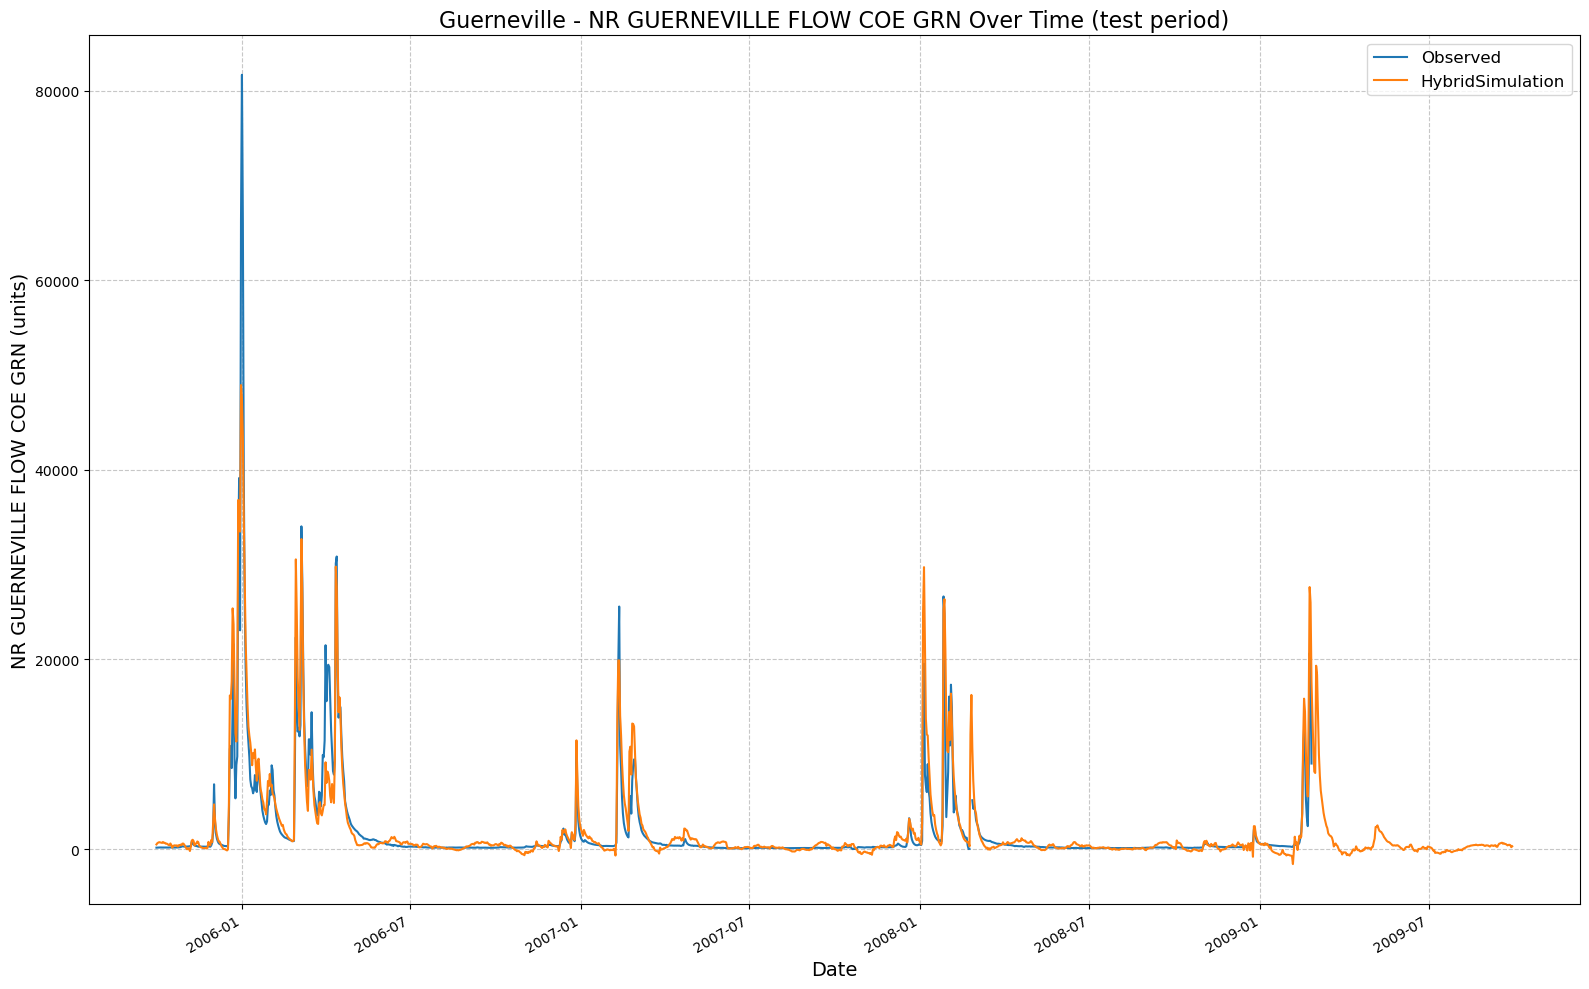

[INFO] CSV output saved at: F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\runs\testing_run_2001_134432\results_output_test.csv


In [21]:
physics_informed_result_metrics, physics_informed_result_path = lstmPhysicsDailyExtended.results('test')

In [22]:
physics_informed_result_metrics

{'NSE': 0.8529672622680664,
 'MSE': 4529185.0,
 'RMSE': 2128.188196565332,
 'KGE': 0.8719063262542106,
 'Alpha-NSE': 0.9479677727868688,
 'Beta-KGE': 1.0893542766571045,
 'Beta-NSE': 0.03128795362791925,
 'Pearson-r': 0.9243927924863016,
 'FHV': -2.8478654101490974,
 'FMS': 10.607107409751132,
 'FLV': 51.962150698474744,
 'Peak-Timing': 1.0,
 'Peak-MAPE': 22.629976272583008}

## Inspect results

In [24]:
    model1_df = pd.read_csv(lstm_result_path) #colums: Date, Observed, Predicted
    model1_df.head()

,Date,Observed,Predicted
0,2005-10-01,149.16675,-165.640140
1,2005-10-02,149.66675,-122.658936
2,2005-10-03,158.87500,-99.525635
3,2005-10-04,168.87500,41.041260
4,2005-10-05,169.95825,82.663086


In [25]:
    model2_df = pd.read_csv(physics_informed_result_path) #colums: Date, Observed, Predicted
    model1_df.head()

,Date,Observed,Predicted
0,2005-10-01,149.16675,-165.640140
1,2005-10-02,149.66675,-122.658936
2,2005-10-03,158.87500,-99.525635
3,2005-10-04,168.87500,41.041260
4,2005-10-05,169.95825,82.663086


In [26]:
    hms_df = clean_daily(pd.read_csv(path_to_physics_data))
    hms_df.head()

,Day,Time,Guerneville Gage FLOW,Big Sulphur Cr ET-POTENTIAL,Big Sulphur Cr FLOW,Big Sulphur Cr FLOW-BASE,Big Sulphur Cr INFILTRATION,Big Sulphur Cr PERC-SOIL,Big Sulphur Cr SATURATION FRACTION,Dry Creek 10 ET-POTENTIAL,...,Russian 70 INFILTRATION,Russian 70 PERC-SOIL,Russian 70 SATURATION FRACTION,Capella Gage FLOW,EF Russian 20 ET-POTENTIAL,EF Russian 20 FLOW,EF Russian 20 FLOW-BASE,EF Russian 20 INFILTRATION,EF Russian 20 PERC-SOIL,EF Russian 20 SATURATION FRACTION
date,,,,,,,,,,,,,,,,,,,,,
1994-10-02,1-Oct-94,24:00:00,227.2199,0.0379,0,0,0,0,0,0.0444,...,0,0,0,481.916626,0.066151,385.320801,385.320801,0,0,0.696838
1994-10-03,2-Oct-94,24:00:00,236.9499,0.0634,0,0,0,0,0,0.0627,...,0,0,0,422.200256,0.110752,325.200256,325.200256,0,0,0.687917
1994-10-04,3-Oct-94,24:00:00,241.5989,0.0558,0,0,0,0,0,0.0536,...,0,0,0,401.010406,0.097419,301.072906,301.072906,0,0,0.677802
1994-10-05,4-Oct-94,24:00:00,292.6814,0.015,1.4238,0,0.3127,0,0.0185,0.0149,...,0.0163,0,0.0008,350.536926,0.026083,271.099426,271.099426,0,0,0.671157
1994-10-06,5-Oct-94,24:00:00,880.0562,0.0306,1.3017,0,0,0,0.0447,0.0443,...,0,0,0.0023,325.131805,0.053415,237.319305,237.319305,0,0,0.670204


 ## Plot combined results

           date  Observed_Model1  Predicted_Model1  Observed_Model2  \
4018 2005-10-01        149.16675          0.000000        149.16675   
4019 2005-10-02        149.66675          0.000000        149.66675   
4020 2005-10-03        158.87500          0.000000        158.87500   
4021 2005-10-04        168.87500         41.041260        168.87500   
4022 2005-10-05        169.95825         82.663086        169.95825   

      Predicted_Model2  HMS_predicted  
4018         489.10680       336.8192  
4019         622.53490       340.1203  
4020         685.54517       341.9980  
4021         728.57400       342.6260  
4022         703.69020       342.2262  


F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\neuralhydrology\guerneville_all\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please

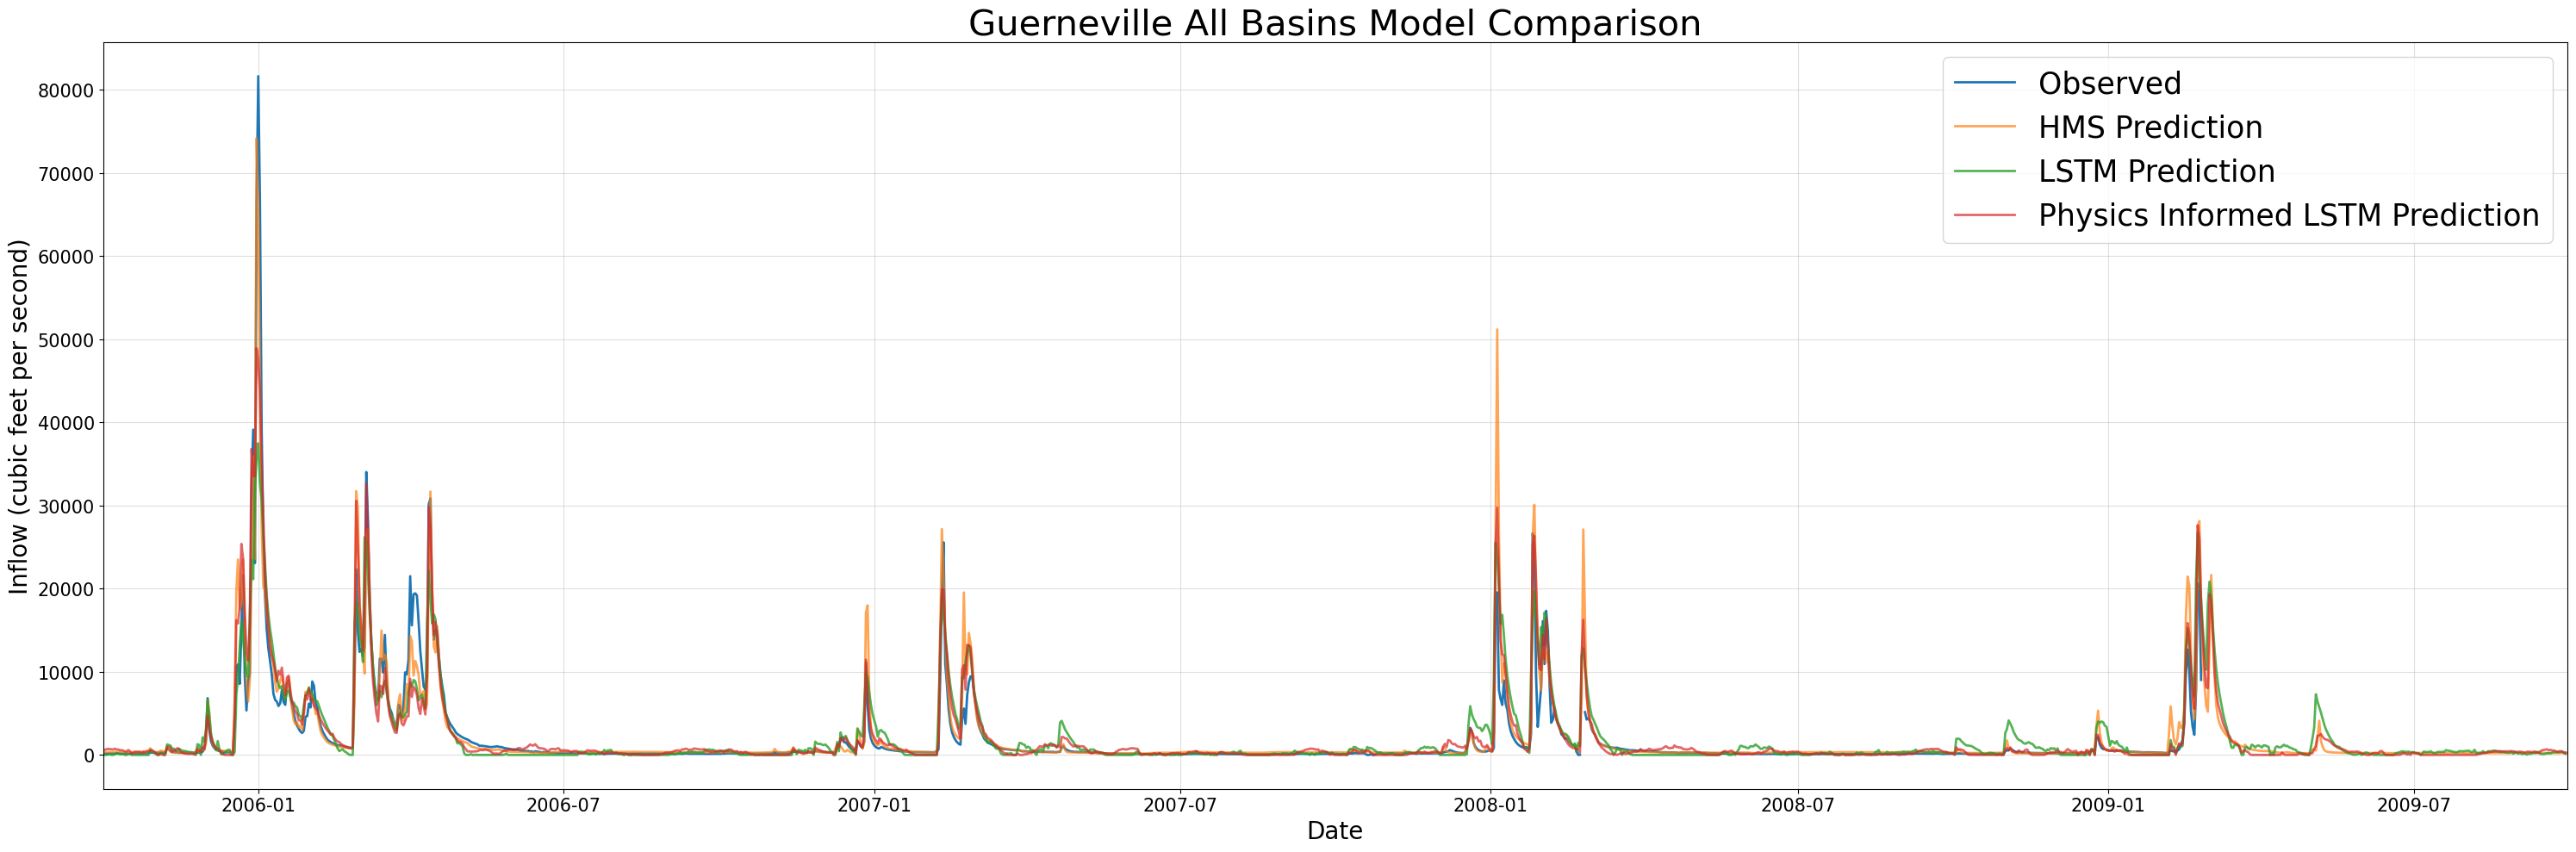

In [28]:
myplot, metrics_df = combinedPlot(lstm_results=lstm_result_path, lstmPhysics_results= physics_informed_result_path, HMS_results=path_to_physics_data, title='Guerneville All Basins Model Comparison', fName = "guerneville_all_basins_metrics.csv")

In [29]:
metrics_df

,HMS,LSTM,Physics_Informed_LSTM
NSE,8.499148e-01,7.640960e-01,8.539281e-01
MSE,4.623214e+06,7.266768e+06,4.499588e+06
RMSE,2.150166e+03,2.695694e+03,2.121223e+03
KGE,8.430313e-01,7.700279e-01,8.593331e-01
Alpha-NSE,1.026757e+00,8.351433e-01,9.454022e-01
Beta-KGE,1.137092e+00,1.101397e+00,1.105776e+00
Beta-NSE,4.800381e-02,3.550495e-02,3.703802e-02
Pearson-r,9.283838e-01,8.757904e-01,9.250482e-01
FHV,2.575220e+00,-2.127571e+01,-2.847865e+00
FMS,-2.409063e+01,1.272362e+02,1.060711e+01
